In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
df = pd.read_excel('Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [34]:
df.drop(['InvoiceNo','StockCode','Description'],axis=1,inplace=True)
df.head()

,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [35]:
df.isnull().sum()

Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [36]:
## We can see that there are too many null values in the 'CustomerID' column. We can impute them with the mode , but then there will be high
## high chances that our final result will be biased. So we will drop these null values.
df = df.dropna(subset=['CustomerID'])
df.isnull().sum()

Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [37]:
df['total_price'] = df['Quantity']*df['UnitPrice']
df.head()

,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_price
0,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [38]:
## calculating recency
df_recency = df.groupby(by='CustomerID',as_index=False)['InvoiceDate'].max()
recent_date = df['InvoiceDate'].max()
df_recency['Recency'] = df_recency['InvoiceDate'].apply(lambda x : (recent_date-x).days)
df_recency.head()

,CustomerID,InvoiceDate,Recency
0,12346.0,2011-01-18 10:17:00,325
1,12347.0,2011-12-07 15:52:00,1
2,12348.0,2011-09-25 13:13:00,74
3,12349.0,2011-11-21 09:51:00,18
4,12350.0,2011-02-02 16:01:00,309


In [39]:
## Calculating frequency
df_frequency = df.drop_duplicates().groupby(by='CustomerID',as_index=False)['InvoiceDate'].count()
df_frequency.columns = ['CustomerID','Frequency']
df_frequency.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,116
2,12348.0,20
3,12349.0,45
4,12350.0,9


In [40]:
## Calculating Monetary
df_monetary = df.drop_duplicates().groupby(by='CustomerID',as_index=False)['total_price'].sum()
df_monetary.columns = ['CustomerID','Monetary']
df_monetary.head()

,CustomerID,Monetary
0,12346.0,0.00
1,12347.0,3125.98
2,12348.0,1399.80
3,12349.0,1209.49
4,12350.0,174.20


In [41]:
rf_df = df_recency.merge(df_frequency,on='CustomerID')
rfm_df = rf_df.merge(df_monetary,on='CustomerID')
rfm_df.drop('InvoiceDate',axis=1,inplace=True)
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,2,0.00
1,12347.0,1,116,3125.98
2,12348.0,74,20,1399.80
3,12349.0,18,45,1209.49
4,12350.0,309,9,174.20


In [42]:
working_df = rfm_df
retain_df = working_df
working_df = working_df.drop('CustomerID',axis=1)
working_df.head()

,Recency,Frequency,Monetary
0,325,2,0.00
1,1,116,3125.98
2,74,20,1399.80
3,18,45,1209.49
4,309,9,174.20


In [43]:
from sklearn.preprocessing import StandardScaler
import pickle
scaler = StandardScaler()
working_df = scaler.fit_transform(working_df)

with open ('Scaler.pkl','wb') as file:
    pickle.dump(scaler,file)

In [44]:
from sklearn.model_selection import train_test_split
x_train,x_test = train_test_split(working_df,test_size=0.3,random_state=42)

In [45]:
## Now we will apply K Means Clustering 
## First we will find optimal value of K using Elbow method
from sklearn.cluster import KMeans
wcss = []

for k in range(1,16) :
    model = KMeans(n_clusters=k,init='k-means++',random_state=42)
    model.fit(x_train)
    wcss.append(model.inertia_)


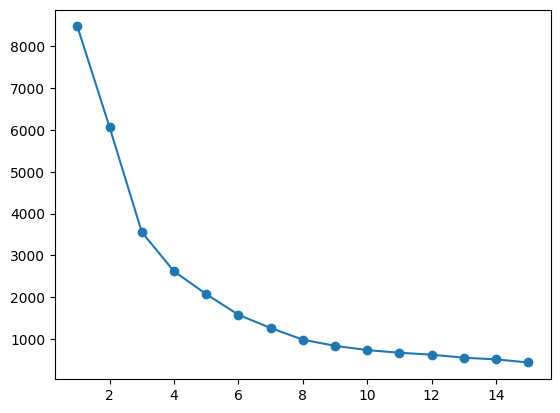

In [46]:
plt.scatter(x=range(1,16),y=wcss)
plt.plot(range(1,16),wcss)
plt.show()

In [47]:
## We can see that here elbow point is at k = 3
kmeans_model = KMeans(n_clusters=3,init='k-means++',random_state=42)
kmeans_model.fit(x_train)

,n_clusters,3
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [48]:
from sklearn.metrics import silhouette_score
training_score = silhouette_score(x_train,kmeans_model.predict(x_train))
print(training_score)

0.5924991682316216


In [49]:
testing_score = silhouette_score(x_test,kmeans_model.predict(x_test))
print(testing_score)

0.5973439109067196


In [50]:
from sklearn.cluster import AgglomerativeClustering
agc_model = AgglomerativeClustering(n_clusters=3)
labels = agc_model.fit_predict(x_train)
training_score = silhouette_score(x_train,labels)
print(training_score)

0.5896819910588871


In [51]:
## We can see that KMeans is performing better than hierarchical clustering. We will use that.
with open('model.pkl','wb') as file:
    pickle.dump(kmeans_model,file)

In [52]:
outputs = kmeans_model.predict(working_df)

In [53]:
retain_df['clutser_id'] = outputs
retain_df.head()

,CustomerID,Recency,Frequency,Monetary,clutser_id
0,12346.0,325,2,0.00,2
1,12347.0,1,116,3125.98,0
2,12348.0,74,20,1399.80,0
3,12349.0,18,45,1209.49,0
4,12350.0,309,9,174.20,2


In [54]:
# Doing analysis for cluster id 0
cluster0_df = retain_df[retain_df['clutser_id'] == 0]
cluster0_df.head()

,CustomerID,Recency,Frequency,Monetary,clutser_id
1,12347.0,1,116,3125.98,0
2,12348.0,74,20,1399.80,0
3,12349.0,18,45,1209.49,0
5,12352.0,35,77,1275.21,0
9,12356.0,22,46,2250.27,0


In [55]:
average_recency = np.average(cluster0_df['Recency'])
average_frequency = np.average(cluster0_df['Frequency'])
average_monetary = np.average(cluster0_df['Monetary'])
print(f"Average Recency for cluster 0 is : {average_recency}")
print(f"Average frequency for cluster 0 is : {average_frequency}")
print(f"Average monetary for cluster 0 is : {average_monetary}")

Average Recency for cluster 0 is : 38.77394518016631
Average frequency for cluster 0 is : 65.9605789959963
Average monetary for cluster 0 is : 1430.2280237141977


In [56]:
# Doing analysis for cluster id 1
cluster1_df = retain_df[retain_df['clutser_id'] == 1]
cluster1_df.head()

,CustomerID,Recency,Frequency,Monetary,clutser_id
55,12415.0,23,463,87090.27,1
330,12748.0,0,2821,21512.33,1
568,13089.0,2,1109,40873.90,1
1300,14096.0,3,1396,30263.29,1
1345,14156.0,9,892,88237.44,1


In [57]:
average_recency = np.average(cluster1_df['Recency'])
average_frequency = np.average(cluster1_df['Frequency'])
average_monetary = np.average(cluster1_df['Monetary'])
print(f"Average Recency for cluster 1 is : {average_recency}")
print(f"Average frequency for cluster 1 is : {average_frequency}")
print(f"Average monetary for cluster 1 is : {average_monetary}")

Average Recency for cluster 1 is : 3.6923076923076925
Average frequency for cluster 1 is : 1623.6923076923076
Average monetary for cluster 1 is : 79646.54230769232


In [58]:
cluster2_df = retain_df[retain_df['clutser_id'] == 2]
cluster2_df.head()

,CustomerID,Recency,Frequency,Monetary,clutser_id
0,12346.0,325,2,0.00,2
4,12350.0,309,9,174.20,2
6,12353.0,203,4,89.00,2
7,12354.0,231,31,585.02,2
8,12355.0,213,9,373.00,2


In [59]:
average_recency = np.average(cluster2_df['Recency'])
average_frequency = np.average(cluster2_df['Frequency'])
average_monetary = np.average(cluster2_df['Monetary'])
print(f"Average Recency for cluster 2 is : {average_recency}")
print(f"Average frequency for cluster 2 is : {average_frequency}")
print(f"Average monetary for cluster 2 is : {average_monetary}")

Average Recency for cluster 2 is : 244.7041366906475
Average frequency for cluster 2 is : 17.992805755395683
Average monetary for cluster 2 is : 342.94045953237406


In [60]:
with open('my_df.pkl','wb') as file:
    pickle.dump(retain_df,file)